# Machine Learning Customer Churn

## Author: Pranav Jonnavithula

## Data Preprocessing

In [4]:
# Importing necessary packages
import pandas as pd
import numpy as np
import plotly.express as px
import statistics
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_selection import chi2, SelectKBest
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import warnings

In [2]:
warnings.filterwarnings("ignore")

#### Importing and cleaning data

In [5]:
# Importing the data
telco_data = pd.read_csv("../Data/Filtered_Data/telco_data.csv")
print(f"Original Telco Data Columns:\n{telco_data.columns.to_list()}\n")
telco_data.head()

# Removing irrelevant columns
telco_data.drop(
    ['Unnamed: 0','LoyaltyID','Customer ID','Location ID',
     'Country','State','Lat Long','Latitude','Longitude','churn_encoded'],
    inplace=True, 
    axis=1
    )

# Separating numeric and categorical features
telco_numeric_features = telco_data.select_dtypes(include = 'number')
telco_categorical_features = telco_data.select_dtypes(include = 'object')

print(f"Numerical features of Telco data:\n{telco_numeric_features.columns.to_list()}\n")
print(f"Categorial features of Telco data:\n{telco_categorical_features.columns.to_list()}\n")

# Creating a list of feature names by combining numeric and categorical feature names
numeric_list = telco_numeric_features.columns.to_list()
cat_list = telco_categorical_features.columns.to_list()
feature_names =  numeric_list + cat_list
print(f"All Features:\n{feature_names}\n")

# Split the data into features and targets
target = telco_data['Churn']
features = telco_data[feature_names]

Original Telco Data Columns:
['Unnamed: 0', 'LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn', 'Count', 'Gender', 'Age', 'Under 30', 'Married', 'Number of Dependents', 'Location ID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'churn_encoded']

Numerical features of Telco data:
['Tenure', 'Monthly Charges', 'Total Charges', 'Count', 'Age', 'Number of Dependents', 'Zip Code']

Categorial features of Telco data:
['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Chu

#### Encoding Target and Features

In [6]:
# Encoding the target variable
le = LabelEncoder()
target = telco_data['Churn'].to_list()
target = le.fit_transform(target)

# Getting the unique values of each categorical variable for custom encoding
for col in features[telco_categorical_features.columns.to_list()]:
    unique_vals = features[col].unique()
    print(f"Unique values in {col}: {unique_vals}")

# Creating dummy variables to encode the categorical variables
yes_no_map = {'Yes':1,'No':0}
services_map = {'Yes':1,'No':0,'No internet service':0}

features['Senior_Citizen_N'] = features['Senior Citizen'].map(yes_no_map)
features['Partner_N'] = features['Partner'].map(yes_no_map)
features['Dependents_N'] = features['Dependents'].map(yes_no_map)
features['Phone_Service_N'] = features['Phone Service'].map(yes_no_map)
features['Multiple_Lines_N'] = features['Multiple Lines'].map({'Yes':1,'No':0,'No phone service':0})
features['Online_Security_N'] = features['Online Security'].map(services_map)
features['Online_Backup_N'] = features['Online Backup'].map(services_map)
features['Device_Protection_N'] = features['Device Protection'].map(services_map)
features['Tech_Support_N'] = features['Tech Support'].map(services_map)
features['Streaming_TV_N'] = features['Streaming TV'].map(services_map)
features['Streaming_Movies_N'] = features['Streaming Movies'].map(services_map)
features['Contract_N'] = features['Contract'].map({'One year':1,'Two year':1,'Month-to-month':0})
features['Paperless_Billing_N'] = features['Paperless Billing'].map(yes_no_map)
features['Payment_Method_N'] = features['Payment Method'].map({'Electronic check':0,'Mailed check':0,'Bank transfer (automatic)':1, 
                                                               'Credit card (automatic)': 1})
features['Gender_N'] = features['Gender'].map({'Male':1,'Female':0})
features['Married_N'] = features['Married'].map(yes_no_map)
features['Under_30_N'] = features['Under 30'].map(yes_no_map)

# Encoding Internet Service using One Hot Encoding and adding it to the features df
Internet_service_df = pd.get_dummies(features['Internet Service'])
Internet_service_df.rename(columns = {"DSL":"DSL_N","Fiber optic":'Fiber_Optic_N',"No":"No_Internet_Service_N"}, inplace=True)
features = pd.concat([features, Internet_service_df], axis=1)

# Encoding City using One Hot Encoding and adding it to the features df
City_df = pd.get_dummies(features['City'])
features = pd.concat([features, City_df], axis=1)

# Removing the original columns from features
features.drop(telco_categorical_features, axis=1, inplace=True)

Unique values in Senior Citizen: ['No' 'Yes']
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in Phone Service: ['No' 'Yes']
Unique values in Multiple Lines: ['No phone service' 'No' 'Yes']
Unique values in Internet Service: ['DSL' 'Fiber optic' 'No']
Unique values in Online Security: ['No' 'Yes' 'No internet service']
Unique values in Online Backup: ['Yes' 'No' 'No internet service']
Unique values in Device Protection: ['No' 'Yes' 'No internet service']
Unique values in Tech Support: ['No' 'Yes' 'No internet service']
Unique values in Streaming TV: ['No' 'Yes' 'No internet service']
Unique values in Streaming Movies: ['No' 'No internet service' 'Yes']
Unique values in Contract: ['Month-to-month' 'One year' 'Two year']
Unique values in Paperless Billing: ['Yes' 'No']
Unique values in Payment Method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Unique values in Churn: ['No' 'Yes']
Unique values 

### Adressing Imbalanced Data

In [5]:
# Checking for target variable imabalance
fig = px.histogram(
    telco_data,
    x = telco_data['Churn'],
    title = "Distribution of target variable",
    color = telco_data['Churn'],
    template='simple_white'
)

fig.update_layout(
    xaxis_title = "Churn",
    yaxis_title = "Count"
)

fig.show()

In [6]:
# Checking for target variable imabalance
fig = px.histogram(
    target,
    x = target[0],
    title = "Distribution of target variable",
    color = target[0],
    template='simple_white'
)

fig.update_layout(
    xaxis_title = "Churn",
    yaxis_title = "Count"
)

fig.show()

### Feature Scaling

In [7]:
# Instantiating a min max scalar
mm = MinMaxScaler()

# Fit and transform the features data to a min max scalar
features_scaled= pd.DataFrame(mm.fit_transform(features))

In [8]:
# Saving data for streamlit app
features.to_csv("../Data/Filtered_Data/features.csv")
target_df = pd.DataFrame(target)
target_df.to_csv("../Data/Filtered_Data/target.csv")

### Train-Test-Split

In [9]:
# Splitting the data into training and testing data (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [10]:
# Addressing the imbalanced data by oversampling using SMOTE
oversample = SMOTE()
X_train, y_train  = oversample.fit_resample(X_train, y_train)

## Model Creation

### Logistic Regression

#### Justification
I have decided to proceed first with logistic regression because one of its uses is to predict discrete outcomes such as group membership from a set of predictor variables that can be continuous, discrete, dichotomous, or a mix, while the target variable is dichotomous. This applies perfectly to my project as the target variable (Churn) is dichotomous and is discrete. 

In [11]:
# Instantiating the model
logistic_reg = LogisticRegression(solver = 'lbfgs', max_iter=1000)

# Training the model with the oversampled train data and normal train data
logistic_reg.fit(X_train, y_train) # oversampled data

# Predicting values with the model
model_prediction_log = logistic_reg.predict(X_test)

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       979
           1       0.53      0.79      0.63       318

    accuracy                           0.78      1297
   macro avg       0.72      0.78      0.74      1297
weighted avg       0.82      0.78      0.79      1297



Confusion Matrix:


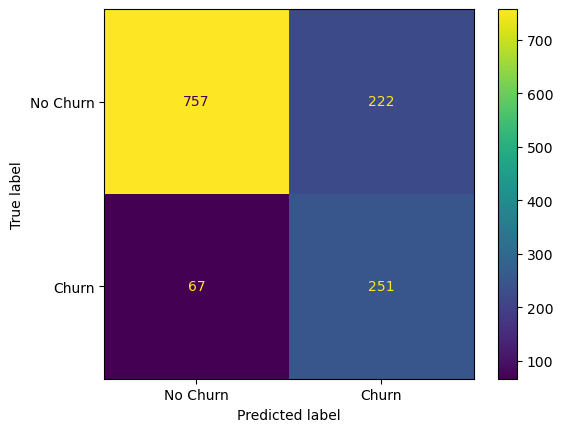


Cross Validation Scores: [0.79936306 0.82292994 0.84203822 0.79872611 0.83566879]
Average Score:0.82
Model Stability (Std Dev of scores):0.02011

ROC Curve:


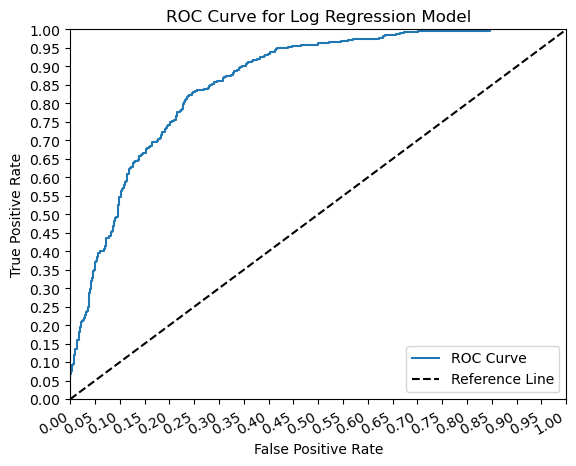

Area Under Curve: 0.86


In [11]:
def model_eval(model, X_train,X_test, y_train, y_test, model_prediction, model_type):
    """A function to create and display a set of model evaluation metrics"""

    # Creating a classification report
    class_report = classification_report(y_test, model_prediction)
    print(f"Classification Report:\n{class_report}\n\n")

    # Creating a confusion matrix
    cnf_matrix = confusion_matrix(y_test, model_prediction)
    cnf_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels=['No Churn','Churn'])
    

    print("Confusion Matrix:")
    cnf_display.plot()
    plt.show()
    print()

    # Cross validation scores
    cross_val_scores = cross_val_score(model, X_train, y_train, cv = 5)
    average_cross_val = cross_val_scores.mean()
    stdev_cross_val = statistics.stdev(cross_val_scores)

    # Printing cross val scores
    print(f"Cross Validation Scores: {cross_val_scores}")
    print(f"Average Score:{round(average_cross_val,2)}")
    print(f"Model Stability (Std Dev of scores):{round(stdev_cross_val,5)}")


    # Creating an ROC curve if the model type is logistic regression
    if model_type.title() == 'Logistic Regression' or model_type.title() == "Log Reg":
        # Printing a title and space for the ROC curve
        print()
        print("ROC Curve:")
        # Getting probability of positive results for better curve
        model_prediction_log_roc = model.predict_proba(X_test)[:, 1] 

        # Obtaining the false positive and true positive rates
        test_fpr, test_tpr, test_threshold = roc_curve(y_test, model_prediction_log_roc)

        # Calculating area under the curve
        roc_auc = metrics.auc(test_fpr, test_tpr)

        # Plotting the curve
        fig,ax = plt.subplots()
        plt.plot(test_fpr, test_tpr, label = "ROC Curve")
        plt.plot([0,1],[0,1], 'k--',label = 'Reference Line') # Creating the reference dashed line
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.legend(loc='lower right') # Creating the legend
        plt.xticks([i/20.0 for i in range(21)]) # Creating 20 x tick labels
        plt.yticks([i/20.0 for i in range(21)]) # Crearing 20 y tick labels
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Log Regression Model")
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment = 'right') # Rotating the x tick labels
        plt.show()

        print(f"Area Under Curve: {round(roc_auc,2)}")



model_eval(logistic_reg, X_train, X_test, y_train, y_test, model_prediction_log,'Logistic Regression')

## Interpretation
### Classification Report
#### Accuracy
With an unbalanced target variable (like I had), it is not common or recommended to rely on the accuracy score to judge a model's performance. However, in my data preprocessing, I used SMOTE technique to oversample the "No" category for churn and hence we can rely on accuracy to judge the model's performance. So when interpreting I will have to take this into account.

For the model where I oversampled the target data, the model accuracy was 77% indicating that the model predicted churn 77% of the time correctly. This score is reliable as our target variable data is now oversampled and not unbalanced. 77% is a good starting point for our accuracy and will improve with further model tuning.

#### Precision
Precision indicates that of all predicted positive results, what fraction were actually positive? In the case of my project the precision score indicates that of all predicted churned customers, what fraction actually churned?

For the logistic regression model with oversampling, the precision score was at 52% indicating that of all predicted churn customers, only 52% actually churned. While this precision score is not great and could be improved with model tuning, for our business context, recal is a much more important measure of model performance than accuracy and precision, and hence we should rely on that metric to develop our analysis

#### Recall
Recall answers the question that of all customers that actually churned, what fraction did we correctly predict as going to churn? In the context of my project and the Telco business, the recall value is at 79%. This indicates that of all customers that actually churned, we predicted almost 80% of them to churn. This is a great score and shows us that this model has potential to be improved and become a stronger predictor. 


### Confusion Matrix
Based on the confusion matrix, we can verify that the recall rate is in fact 79% (251/318) and the precision rate is 52% (251/480). From the confusion matrix, we can see that the false negative rate of 21% (67/318) is at a relatively low rate. This is a great sign for our baseline model as a low false negative rate means that we are more likely to predict a customer will churn when they actually do, rather than predicting them to not churn when they actually churn. This presents a great opportunity for Telco to increase its revenue and its ROI. The false positive rate is now 23.1% indicating that our model falsely flags 23% of customers as "churning" when in fact they do not plan to churn. This result could be a bit lower to be a bit more desirable but luckily our business problem is to focus mainly on the reduction of false negatives.

### Cross Validation Scores
The average accuracy of our model across 5 different "folds" or splits is 82% indicating that our model performs well with unseen data and has avoided being overfit to the training data. Moreover, the standard deviation of 1.4% indicates stability in our model to consistently perform well with unseen datasets. Therefore, we can be confident that this logistic regression model will perform well with new data for new Telco customers.

### ROC Curve
The ROC curve is one of the evaluation methods inherent to logistic regression. I chose to use it as an evaluation metric because it showcases the false positive vs true positive rate which is important in my business context (correctly predicting churn vs predicting churned customer when they do not churn). 

From the graph, we can see that my logistic regression model is quite strong. The area under the curve of 86% indicates strong prediction power and the large curve (compared to the reference line) indicates a low error, high power prediction model

## Logistic Model Improvement

## Feature Selection 

### Chi squared

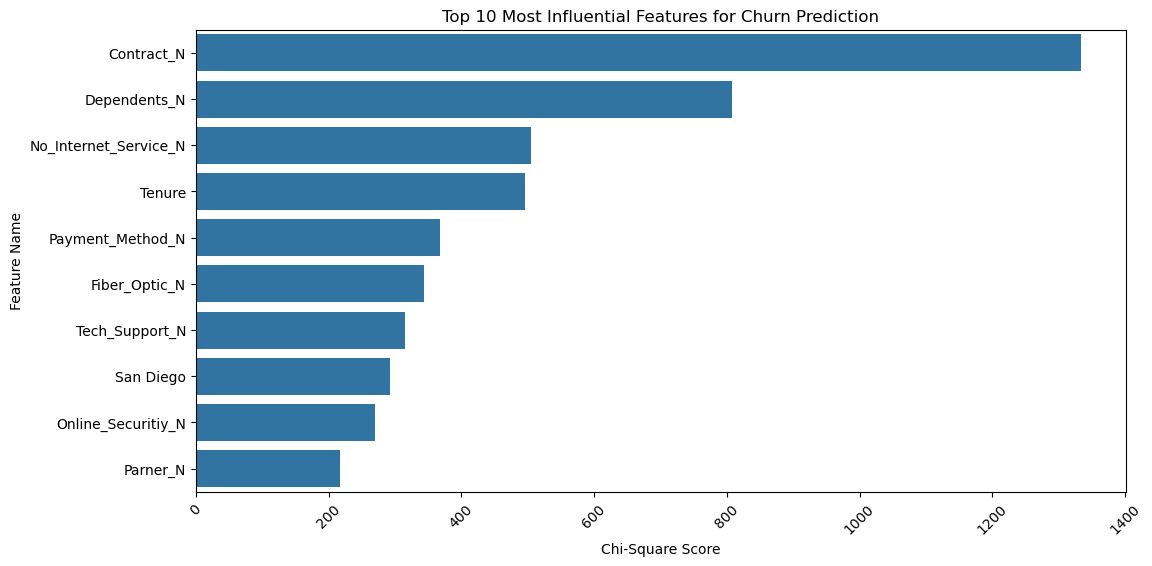

In [12]:
def chi2_feature_selector(k, plot):
    """A function to use chi2 feature selection to select features based on a K input"""
    
    # Using a filtering method of feature selection - chi squared
    selector = SelectKBest(score_func = chi2, k=k)

    # Transforming the X_train and X_test with the selected features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Training the logistic regression model
    logistic_reg_selected = LogisticRegression()
    logistic_reg_selected.fit(X_train_selected, y_train)

    # Predicting values
    model_prediction_log_selected = logistic_reg_selected.predict(X_test_selected)

    if plot.title() =='Yes' or plot.title() == 'Y':
        # Selected features
        X_train_selected_df = pd.DataFrame(X_train_selected, columns = X_train.columns[selector.get_support()])

        feature_scores = pd.DataFrame({
            'Feature':X_train.columns,
            'Importance': selector.scores_
        })

        # Sorting the feature scored by the top values
        feature_scores = feature_scores.sort_values('Importance',ascending=False)
        
        col_names = []
        for col_num in feature_scores['Feature']:
            col_names.append(features.columns[col_num])
        
        feature_scores['col_name'] = col_names

        # Create visualization
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='col_name', data=feature_scores.head(10))
        plt.title('Top 10 Most Influential Features for Churn Prediction')
        plt.xlabel('Chi-Square Score')
        plt.ylabel('Feature Name')
        plt.xticks(rotation=45)

        plt.show()
        
    return model_prediction_log_selected, X_train_selected, X_test_selected

model_prediction_log_selected_10 = chi2_feature_selector(10,'yes')[0]
model_prediction_log_selected_5 = chi2_feature_selector(5,'no')[0]
model_prediction_log_selected_2 = chi2_feature_selector(2,'no')[0]

### Interpretation
- The graph "Top 10 Most Influential Features for Churn Prediction" show cases that the contract length is the number one most influencial predictor of a customer churning. This is in fact intuitive as a customer with a longer contract term (1 year, or 2 years) will be less likely to leave Telco and churn than those customers with month-to-month (shorter term) contracts. 
- The next most influencial variable is the number of dependents a customer has. This also makes sense if we take into account families who sign up for Telco services. Usually, one person in the family signs up and has their family members as dependents. Therefore, the more family memebrs that person has, the less likely they are to change providers due to the large amount of inconvenience it would take to switch all their famliy members to the new service. 
- Obviously, as the tenure (length of time a customer is with Telco) increases, the less likely they are to churn due to inconvenience to switch providers
- Customers who sign on with Telco but do not obtain internet service are also less likely to churn.

### Evaluation

In [13]:
# Evaluating the new models

# 10 Features
class_report_log_selected_10 = classification_report(y_test, model_prediction_log_selected_10)
print(f"Classification report of logistic regression with 10 feature selection:\n{class_report_log_selected_10}\n")

# 5 Features
class_report_log_selected_5 = classification_report(y_test, model_prediction_log_selected_5)
print(f"Classification report of logistic regression with 5 feature selection:\n{class_report_log_selected_5}\n")

# 2 Features
class_report_log_selected_2 = classification_report(y_test, model_prediction_log_selected_2)
print(f"Classification report of logistic regression with 2 feature selection:\n{class_report_log_selected_2}\n")



Classification report of logistic regression with 10 feature selection:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       979
           1       0.53      0.82      0.65       318

    accuracy                           0.78      1297
   macro avg       0.73      0.79      0.74      1297
weighted avg       0.83      0.78      0.79      1297


Classification report of logistic regression with 5 feature selection:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       979
           1       0.49      0.85      0.62       318

    accuracy                           0.75      1297
   macro avg       0.71      0.78      0.71      1297
weighted avg       0.83      0.75      0.76      1297


Classification report of logistic regression with 2 feature selection:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       979
           1       0.

### Interpretation
By utilizing chi squared feature selection, I have created 3 different models with different feature selections. I have created a model with the top 10 features that influence churn (determined by chi squared value), the top 5 features, and then the top 2 features. 

#### 10 Features
- After creating a model with k=10 features and displaying the classification report, we can see that the overall accuracy of the model is at 78% (a 1 % improvement from the default oversampled model) indicating that the model accurately predicts if a customer will churn 78% of the time. 
- The precision score is now 53% (a 1% improvement from the default oversampled model), indicating that of all predicted churn customers, 53% actually churned. This indicates that the false positive rate is quite high in this model, however, if we look at the business context, we would rather have a high false positive rate (predicting a customer will churn when they will not), then a false negative (predicting a customer will stay when they will churn).
- The recall score in this model is now 82% (a 4% increase form the base model). This value indicates that of all customers who actually churned, our model predicted 82% of them to churn. This metric is a very significant indicator of the success of the model as it predicts the false negative rate (predicting a customer will stay when they will actually churn). An 82% recall score is very desirable because it would greatly increase Telco revenues by predicting a customer will churn when they actually will and hence can implement customer retention strategies to influence the customer to stay.


#### 5 Features
- With the model with 5 features, we can see that the overall accuracy score is at 74% (3% decrease from default model) indicating that the model accurately predicts if a customer will churn 74% of the time. This is a slight decrease from the 10 feature model and can be a cause for concern
- The precision score of 49% (a 3% decrease from the base model) indicates that of all of the predicted churn customers, how many actually churned? This lower number shows us that the false positive rate is rising as the features decrease. While our project values a lower false negative rate more than a lower false positive rate, a high false positive rate could indicate more resource allocation to address false positives. 
- The recall score is now even higher at 86% indicating that of all customers who churned, our model predicted 86% of them to churn. A higher recall value is always desirable due to the aforementioned reasons, however, we will need to balance the increasing false positive rate with the low false negative rate.


#### 2 Features
- The model with 2 features has an overall accuracy score of 72% (5% decrease from default model). The decreased accuracy indicates that as the number of features decrease, the overall prediction accuracy decreases. 
- the precision score of 46% (a 6% decrease from the base model) shows that the false negative rate is increasing as the K (number of features) decreases. While our model mainly focuses on minimizing false negatives, the prevalance of false positives will also be resource extensive in terms of customer retention strategies and hence should be minimized as well. 
- The recall score of 90% showcases an extremely low false negative rate. This is a very good sign for our model as it correctly identifies a lot of customers who will churn. However, we need to be careful by looking at the rising false positive rate and balance accordingly.

### Overall Pick
After analyzing 3 different models with the varied number of features, **I will proceed with the model with 10 features** as it balances the rate of false negatives with false positives, while also maintaing a relatively high accuracy rate compared to the base model. While the other two models have a very low false negative rate, the trade off with the false positive rate and overall model accuracy will not produce a great ROI for Telco. 

Confusion Matrix:


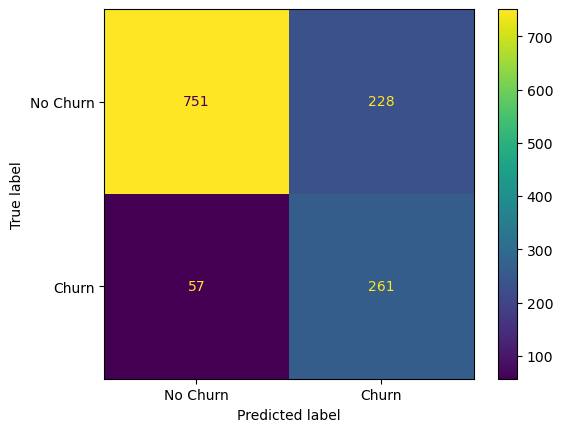


Cross Validation Scores: [0.78535032 0.78471338 0.80573248 0.76687898 0.79872611]
Average Score:0.79
Model Stability (Std Dev of scores):0.01494


In [15]:
# Confusion Matrix Display
cnf_matrix = confusion_matrix(y_test, model_prediction_log_selected_10)
cnf_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels=['No Churn','Churn'])
    
print("Confusion Matrix:")
cnf_display.plot()
plt.show()
print()

# Cross Validation Scores
cross_val_scores = cross_val_score(logistic_reg, chi2_feature_selector(10,'no')[1], y_train, cv = 5)
average_cross_val = cross_val_scores.mean()
stdev_cross_val = statistics.stdev(cross_val_scores)

# Printing cross val scores
print(f"Cross Validation Scores: {cross_val_scores}")
print(f"Average Score:{round(average_cross_val,2)}")
print(f"Model Stability (Std Dev of scores):{round(stdev_cross_val,5)}")


## Interpretation

### Confusion Matrix
The new confusion matrix (k=10 features) displays a false negative rate of 18.6% (59/318) which is a significant improvement from the base model of 21% false positive rate. This metric is one of the most important metrics especially in the context of Telco and indicates that my model is proving to be very strong and reliable to be used in the company. Moreover, we can see no real improvement in the false positive rate with both models having a 23% false positive rate. All in all, the confusion matrix for this improved model reveals that selecting the top 10 features greatly helps in improving the model's prediction power and reducing errors and will be a great investment for Telco.

### Cross Validation
Over 5 different dataset splits or "folds", my model had an average accuracy of 79%. This accuracy score is great and showcases strong model performance over unseen data. While it is slighly lower than the previous logistic regression model (no chi2 feature selection), the accuracy is still high enough to be considered a very accurate model. 

Moreover, the standard deviation of 0.65% reveals that the model is even more stable than the previous logistic regression model as the accuracy score does not change drastically for each of the 5 folds.

## Random Forest Model

### Justification
Random Forest is an ensemble method of machine learning, meaning that they take the input from multiple machine learning models to come up with a prediction. Random Forest uses the input from multiple decision trees to come up with an aggregated prediction. It can be used for classification and on smaller datasets and hence can be applicable to my churn prediction scenario

### Model Creation

In [14]:
# Initializing a random forest model
rf = RandomForestClassifier()

# Getting the chi-sq 10 variables
selector = SelectKBest(score_func=chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Training the model
rf.fit(X_train_selected, y_train)

# Predicting with the model
model_prediction_rf = rf.predict(X_test_selected)

### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       979
           1       0.53      0.61      0.57       318

    accuracy                           0.77      1297
   macro avg       0.70      0.72      0.71      1297
weighted avg       0.79      0.77      0.78      1297



Confusion Matrix:


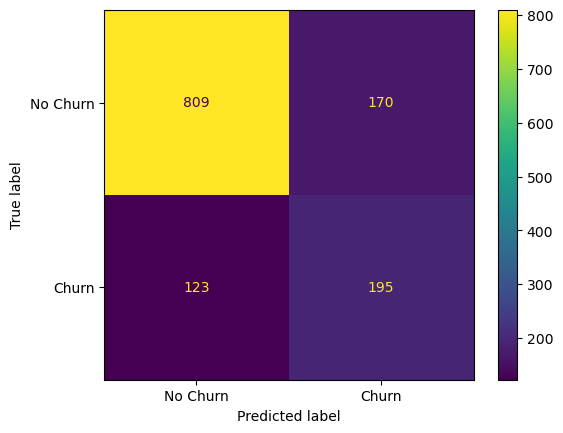


Cross Validation Scores: [0.69426752 0.80828025 0.8656051  0.85159236 0.86305732]
Average Score:0.82
Model Stability (Std Dev of scores):0.07214


In [15]:
# Running the model evaluation function
model_eval(rf, X_train_selected, X_test_selected, y_train, y_test, model_prediction_rf,'Random Forest')

## Interpretation
### Classification Report
#### Accuracy
When using the Random Forest classifier and parameter selection, we notice that the accuracy score of 77% (k=10) is quite similar to our previous logistic regression model at 78%. This indicates that both models do a good job at correctly predicting when a customer will churn and when they will not churn. However, with further hyperparameter tuning, this result can be improved. 

#### Precision
Precision answers the question of all predicted churn customers, how many actually churned? With this random forest model, that percentage is 53% which is the same as the logistic regression model value of 53% as well. The precision score tells us that the false positive rate is quite high in both models. Luckily, for our situation, a false positive is not detrimental to the company, so much so as a false negative. 

#### Recall
Recall answers the question that of all customers that actually churned, what fraction did we actually predict would churn. With the random forest model, we predicted 60% of all customers who actually churned, to churn. This number indicates a very high false negative rate. A high false negative rate would be detrimental to Telco's revenue as our model would be incorrectly labelling churning customers as "safe". 

### Confusion Matrix
The confusion matrix showcases that on average, our model predicts a customer will churn when in reality they do not about 16% of the time. On the other hand, our model predicts a customer will not churn, when they in fact do churn about 40% of the time. This large false negative value (40%) indicates that our model is in fact not that reliable for our business use case as having a large number of false negatives will severely impact company revenue and customer base.

### Cross Validation scores
The random forest classifier showcases a very large average accuracy score across 5 different training sets using cross validation at 81%. However, the standard deviation seems to be slightly larger than the logistic regression models at 7.2% indicating that the model stability may be lacking in certain unseen data sets. 

### Hyperparameter Tuning

In [16]:
# Defining the parameters to tune
param_dist = {
    'n_estimators': randint(50,500),
    'max_depth': randint(1,20)
}

# Creating the randomized search object
rand_search = RandomizedSearchCV(
    rf,
    param_distributions = param_dist,
    n_iter = 5, # number of times the search cv will run
    cv = 5 # the number of cross validation scores
)

# Fitting the random search to training data
rand_search.fit(X_train_selected, y_train)

# Creating a variable for the best model
best_rf = rand_search.best_estimator_
print(f"Best Parameters:{rand_search.best_params_}")

Best Parameters:{'max_depth': 11, 'n_estimators': 413}


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       979
           1       0.55      0.76      0.64       318

    accuracy                           0.79      1297
   macro avg       0.73      0.78      0.74      1297
weighted avg       0.82      0.79      0.80      1297



Confusion Matrix:


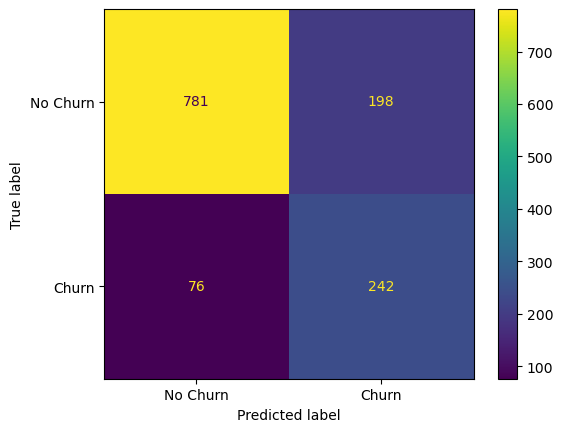


Cross Validation Scores: [0.77961783 0.82993631 0.86815287 0.84267516 0.86433121]
Average Score:0.84
Model Stability (Std Dev of scores):0.03568


In [19]:
model_eval(best_rf, X_train_selected, X_test_selected, y_train, y_test, model_prediction_rf_best,'Random Forest')

## Interpretation
### Classification Report
#### Accuracy
The new "best" model, determined by the RandomizedSearchCV (hyperparameter tuning) has a 1% improved accuracy from the original model (77% -> 78%). This improvement is quite insignificant and shows that the random forest model's improvement metrics are small and may not be of much help at all. 

#### Precision
The hyperparameter tuning improved the precision by a very small 2% to bring it up to 55%. This improvement is not significant in the grand scheme of the project and still indicates a weak precision score. 

#### Recall
The hyperparameter tuning helped increase the recall score immensely from 61% to 76%. However, while this 15% improevement is very significant, it is still lags behind the 83% recall score of the logistic regression model. Therefore, the Logistic regression model would still be desirable in terms of precision and recall.

### Confusion Matrix
The false positive rate with the hyperparameter tuning has increased from 16% (base model) to 20% in this new model. This indicates a sharp increase in false positive rate, and while it is not too important in our business context, a low false positive rate is still desirable.

The false negative rate of 23% indicates a dramatic fall from the base model. This new hypertuned model falsely flags a customer as not churning when they are churning 23% of the time which is a drastic improvement from the previous 40%. 

### Cross Validation
The Hypertuned model showcases slight improvements in the cross vlaidation average accuracy score from 82% to 84%. On the other hand, the standard deviation of cross validation scores also shows a small, but better improvement than the avergae score going from 7% to 3%. Overall, the cross validation socres indicate that the model performs well on unseen datasets and indicates that the model was not overfit to the training data.